In [1]:
!pip install -q segmentation-models-pytorch tqdm albumentations 
# !pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.0 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms as T
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from skimage.segmentation import active_contour
from skimage import img_as_float
from skimage.draw import polygon2mask
from skimage.segmentation import chan_vese
from skimage import measure

# from ultralytics import YOLO
from google.colab.patches import cv2_imshow

In [3]:
# Sử dụng 2 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")

Using device: cuda
Using 2 GPUs


# U-Net

In [4]:
class CellSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted(os.listdir(images_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, f"MASK_{os.path.splitext(img_name)[0]}.png")

        # Đọc ảnh RGB bằng cv2, convert từ BGR sang RGB
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Đọc mask grayscale (nhị phân)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # Convert mask về tensor và chuẩn hóa 0/1 float
        if isinstance(mask, np.ndarray):
            mask = torch.from_numpy((mask > 0).astype("np.int64"))
        elif isinstance(mask, torch.Tensor):
            mask = (mask > 0).long()
        else:
            raise TypeError(f"Unsupported mask type: {type(mask)}")

        # Nếu mask 2D thì thêm channel dim
        if mask.dim() == 2:
            mask = mask.unsqueeze(0)

        return image, mask


# train_transform = A.Compose([
#     A.Resize(256, 256),
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
#     ToTensorV2()
# ])
train_transform = A.Compose([
    A.Resize(256, 256),

    # Flip ngang/dọc
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),

    # Xoay ±15 độ (nhẹ hơn so với 30)
    A.Rotate(limit=15, p=0.5),

    # Crop nhẹ (chỉ zoom in/out một chút)
    A.RandomResizedCrop(size=(256, 256), scale=(0.9, 1.0), p=0.3),

    # Affine rất nhẹ (dịch chuyển nhỏ, không shear)
    A.Affine(scale=(0.95, 1.05), translate_percent=(0.02, 0.02), rotate=(-10, 10), p=0.3),

    # Chuẩn hóa và Tensor
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])

#val/test
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])

In [5]:
base_dir = "/kaggle/input/cell-counting-roboflow-segmentation-masks/Cell_Counting_dataset_from_roboflow"

train_dataset = CellSegDataset(
    images_dir=os.path.join(base_dir, "train/images"),
    masks_dir=os.path.join(base_dir, "train/masks_binary"),
    transform=train_transform
)

val_dataset = CellSegDataset(
    images_dir=os.path.join(base_dir, "valid/images"),
    masks_dir=os.path.join(base_dir, "valid/masks_binary"),
    transform=test_transform
)

test_dataset = CellSegDataset(
    images_dir=os.path.join(base_dir, "test/images"),
    masks_dir=os.path.join(base_dir, "test/masks_binary"),
    transform=test_transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

print(f"Train samples: {len(train_dataset)}, Valid samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 93, Valid samples: 10, Test samples: 4


In [6]:
model = smp.Unet(
        encoder_name="resnet152",
        encoder_weights="imagenet",
        classes=2,
        activation=None,  
    )
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Model parameters: 67,157,026


In [7]:
class DiceLoss(nn.Module):
    """Dice Loss cho segmentation"""
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, predictions, targets):
        predictions = torch.softmax(predictions, dim=1)
        predictions = predictions[:, 1, :, :]  # Chỉ lấy class 1 (tế bào)
        targets = targets.float()
        
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    """Kết hợp CrossEntropy và Dice Loss"""
    def __init__(self, weight_ce=0.5, weight_dice=0.5):
        super(CombinedLoss, self).__init__()
        self.weight_ce = weight_ce
        self.weight_dice = weight_dice
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_loss = DiceLoss()
    
    def forward(self, predictions, targets):
        targets_ce = targets.squeeze(1).long() if targets.dim() == 4 else targets.long()
        ce = self.ce_loss(predictions, targets_ce)
        
        targets_dice = targets.float().squeeze(1) if targets.dim() == 4 else targets.float()
        dice = self.dice_loss(predictions, targets_dice)
        return self.weight_ce * ce + self.weight_dice * dice

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-3):
    """Training function"""
    # Sử dụng DataParallel nếu có nhiều GPU
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model.to(device)
    
    criterion = CombinedLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Train')
        
        for images, masks in train_pbar:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            masks_ce = masks.squeeze(1).long()
            loss = criterion(outputs, masks_ce)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_pbar.set_postfix({'loss': loss.item()})
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Val')
        
        with torch.no_grad():
            for images, masks in val_pbar:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                masks_ce = masks.squeeze(1).long()
                loss = criterion(outputs, masks_ce)
                val_loss += loss.item()
                val_pbar.set_postfix({'loss': loss.item()})
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_unet_model.pth')
            print(f'Best model saved with val_loss: {val_loss:.4f}')
        
        print('-' * 50)
    
    return model, train_losses, val_losses

Training model...


Epoch 1/100 - Val: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s, loss=13.7]


Epoch 1/100:
Train Loss: 0.5939, Val Loss: 17.0059
Best model saved with val_loss: 17.0059
--------------------------------------------------


Epoch 2/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s, loss=0.335]


Epoch 2/100:
Train Loss: 0.4010, Val Loss: 0.3480
Best model saved with val_loss: 0.3480
--------------------------------------------------


Epoch 3/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s, loss=0.316]


Epoch 3/100:
Train Loss: 0.3350, Val Loss: 0.3318
Best model saved with val_loss: 0.3318
--------------------------------------------------


Epoch 4/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s, loss=0.303]


Epoch 4/100:
Train Loss: 0.3030, Val Loss: 0.2962
Best model saved with val_loss: 0.2962
--------------------------------------------------


Epoch 5/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.92it/s, loss=0.267]


Epoch 5/100:
Train Loss: 0.2867, Val Loss: 0.2624
Best model saved with val_loss: 0.2624
--------------------------------------------------


Epoch 6/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s, loss=0.264]


Epoch 6/100:
Train Loss: 0.2696, Val Loss: 0.2626
--------------------------------------------------


Epoch 7/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s, loss=0.231]


Epoch 7/100:
Train Loss: 0.2659, Val Loss: 0.2470
Best model saved with val_loss: 0.2470
--------------------------------------------------


Epoch 8/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.62it/s, loss=0.221]


Epoch 8/100:
Train Loss: 0.2714, Val Loss: 0.2130
Best model saved with val_loss: 0.2130
--------------------------------------------------


Epoch 9/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.64it/s, loss=0.218]


Epoch 9/100:
Train Loss: 0.2487, Val Loss: 0.2453
--------------------------------------------------


Epoch 10/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s, loss=0.225]


Epoch 10/100:
Train Loss: 0.2448, Val Loss: 0.3454
--------------------------------------------------


Epoch 11/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s, loss=0.242]


Epoch 11/100:
Train Loss: 0.2444, Val Loss: 0.3366
--------------------------------------------------


Epoch 12/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s, loss=0.322]


Epoch 12/100:
Train Loss: 0.2344, Val Loss: 0.4579
--------------------------------------------------


Epoch 13/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s, loss=0.204]


Epoch 13/100:
Train Loss: 0.2247, Val Loss: 0.2162
--------------------------------------------------


Epoch 14/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s, loss=0.211]


Epoch 14/100:
Train Loss: 0.2357, Val Loss: 0.2266
--------------------------------------------------


Epoch 15/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s, loss=0.18]


Epoch 15/100:
Train Loss: 0.2322, Val Loss: 0.1935
Best model saved with val_loss: 0.1935
--------------------------------------------------


Epoch 16/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.65it/s, loss=0.193]


Epoch 16/100:
Train Loss: 0.2083, Val Loss: 0.1941
--------------------------------------------------


Epoch 17/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s, loss=0.178]


Epoch 17/100:
Train Loss: 0.2071, Val Loss: 0.1811
Best model saved with val_loss: 0.1811
--------------------------------------------------


Epoch 18/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s, loss=0.177]


Epoch 18/100:
Train Loss: 0.2098, Val Loss: 0.1938
--------------------------------------------------


Epoch 19/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.77it/s, loss=0.196]


Epoch 19/100:
Train Loss: 0.2059, Val Loss: 0.2019
--------------------------------------------------


Epoch 20/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s, loss=0.18]


Epoch 20/100:
Train Loss: 0.2101, Val Loss: 0.1875
--------------------------------------------------


Epoch 21/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.80it/s, loss=0.186]


Epoch 21/100:
Train Loss: 0.2089, Val Loss: 0.1880
--------------------------------------------------


Epoch 22/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s, loss=0.19]


Epoch 22/100:
Train Loss: 0.2066, Val Loss: 0.2107
--------------------------------------------------


Epoch 23/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s, loss=0.18]


Epoch 23/100:
Train Loss: 0.2038, Val Loss: 0.1865
--------------------------------------------------


Epoch 24/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.84it/s, loss=0.179]


Epoch 24/100:
Train Loss: 0.1982, Val Loss: 0.1809
Best model saved with val_loss: 0.1809
--------------------------------------------------


Epoch 25/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.70it/s, loss=0.182]


Epoch 25/100:
Train Loss: 0.1890, Val Loss: 0.1807
Best model saved with val_loss: 0.1807
--------------------------------------------------


Epoch 26/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.80it/s, loss=0.171]


Epoch 26/100:
Train Loss: 0.1854, Val Loss: 0.1751
Best model saved with val_loss: 0.1751
--------------------------------------------------


Epoch 27/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.66it/s, loss=0.169]


Epoch 27/100:
Train Loss: 0.1837, Val Loss: 0.1747
Best model saved with val_loss: 0.1747
--------------------------------------------------


Epoch 28/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s, loss=0.171]


Epoch 28/100:
Train Loss: 0.1835, Val Loss: 0.1758
--------------------------------------------------


Epoch 29/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s, loss=0.174]


Epoch 29/100:
Train Loss: 0.1832, Val Loss: 0.1886
--------------------------------------------------


Epoch 30/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s, loss=0.174]


Epoch 30/100:
Train Loss: 0.1804, Val Loss: 0.1809
--------------------------------------------------


Epoch 31/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.90it/s, loss=0.16]


Epoch 31/100:
Train Loss: 0.1707, Val Loss: 0.1688
Best model saved with val_loss: 0.1688
--------------------------------------------------


Epoch 32/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.65it/s, loss=0.161]


Epoch 32/100:
Train Loss: 0.1789, Val Loss: 0.1658
Best model saved with val_loss: 0.1658
--------------------------------------------------


Epoch 33/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s, loss=0.161]


Epoch 33/100:
Train Loss: 0.1727, Val Loss: 0.1670
--------------------------------------------------


Epoch 34/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s, loss=0.175]


Epoch 34/100:
Train Loss: 0.1721, Val Loss: 0.1747
--------------------------------------------------


Epoch 35/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s, loss=0.17]


Epoch 35/100:
Train Loss: 0.1772, Val Loss: 0.1883
--------------------------------------------------


Epoch 36/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.86it/s, loss=0.162]


Epoch 36/100:
Train Loss: 0.1770, Val Loss: 0.1668
--------------------------------------------------


Epoch 37/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.60it/s, loss=0.17]


Epoch 37/100:
Train Loss: 0.1714, Val Loss: 0.1712
--------------------------------------------------


Epoch 38/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s, loss=0.163]


Epoch 38/100:
Train Loss: 0.1694, Val Loss: 0.1723
--------------------------------------------------


Epoch 39/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.84it/s, loss=0.162]


Epoch 39/100:
Train Loss: 0.1709, Val Loss: 0.1675
--------------------------------------------------


Epoch 40/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.65it/s, loss=0.167]


Epoch 40/100:
Train Loss: 0.1678, Val Loss: 0.1741
--------------------------------------------------


Epoch 41/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s, loss=0.159]


Epoch 41/100:
Train Loss: 0.1643, Val Loss: 0.1659
--------------------------------------------------


Epoch 42/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s, loss=0.158]


Epoch 42/100:
Train Loss: 0.1700, Val Loss: 0.1629
Best model saved with val_loss: 0.1629
--------------------------------------------------


Epoch 43/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.52it/s, loss=0.166]


Epoch 43/100:
Train Loss: 0.1637, Val Loss: 0.1657
--------------------------------------------------


Epoch 44/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s, loss=0.168]


Epoch 44/100:
Train Loss: 0.1627, Val Loss: 0.1724
--------------------------------------------------


Epoch 45/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s, loss=0.163]


Epoch 45/100:
Train Loss: 0.1646, Val Loss: 0.1717
--------------------------------------------------


Epoch 46/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s, loss=0.161]


Epoch 46/100:
Train Loss: 0.1585, Val Loss: 0.1673
--------------------------------------------------


Epoch 47/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.78it/s, loss=0.16]


Epoch 47/100:
Train Loss: 0.1581, Val Loss: 0.1646
--------------------------------------------------


Epoch 48/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s, loss=0.16]


Epoch 48/100:
Train Loss: 0.1534, Val Loss: 0.1667
--------------------------------------------------


Epoch 49/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.86it/s, loss=0.16]


Epoch 49/100:
Train Loss: 0.1592, Val Loss: 0.1709
--------------------------------------------------


Epoch 50/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.84it/s, loss=0.16]


Epoch 50/100:
Train Loss: 0.1574, Val Loss: 0.1665
--------------------------------------------------


Epoch 51/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s, loss=0.162]


Epoch 51/100:
Train Loss: 0.1573, Val Loss: 0.1630
--------------------------------------------------


Epoch 52/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s, loss=0.16]


Epoch 52/100:
Train Loss: 0.1529, Val Loss: 0.1662
--------------------------------------------------


Epoch 53/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s, loss=0.16]


Epoch 53/100:
Train Loss: 0.1576, Val Loss: 0.1668
--------------------------------------------------


Epoch 54/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s, loss=0.162]


Epoch 54/100:
Train Loss: 0.1501, Val Loss: 0.1660
--------------------------------------------------


Epoch 55/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s, loss=0.163]


Epoch 55/100:
Train Loss: 0.1546, Val Loss: 0.1657
--------------------------------------------------


Epoch 56/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s, loss=0.159]


Epoch 56/100:
Train Loss: 0.1549, Val Loss: 0.1619
Best model saved with val_loss: 0.1619
--------------------------------------------------


Epoch 57/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s, loss=0.159]


Epoch 57/100:
Train Loss: 0.1538, Val Loss: 0.1636
--------------------------------------------------


Epoch 58/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s, loss=0.159]


Epoch 58/100:
Train Loss: 0.1554, Val Loss: 0.1644
--------------------------------------------------


Epoch 59/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s, loss=0.16]


Epoch 59/100:
Train Loss: 0.1514, Val Loss: 0.1651
--------------------------------------------------


Epoch 60/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s, loss=0.158]


Epoch 60/100:
Train Loss: 0.1555, Val Loss: 0.1631
--------------------------------------------------


Epoch 61/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s, loss=0.158]


Epoch 61/100:
Train Loss: 0.1526, Val Loss: 0.1623
--------------------------------------------------


Epoch 62/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s, loss=0.158]


Epoch 62/100:
Train Loss: 0.1539, Val Loss: 0.1614
Best model saved with val_loss: 0.1614
--------------------------------------------------


Epoch 63/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s, loss=0.157]


Epoch 63/100:
Train Loss: 0.1509, Val Loss: 0.1619
--------------------------------------------------


Epoch 64/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s, loss=0.157]


Epoch 64/100:
Train Loss: 0.1505, Val Loss: 0.1619
--------------------------------------------------


Epoch 65/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s, loss=0.157]


Epoch 65/100:
Train Loss: 0.1505, Val Loss: 0.1604
Best model saved with val_loss: 0.1604
--------------------------------------------------


Epoch 66/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s, loss=0.16]


Epoch 66/100:
Train Loss: 0.1510, Val Loss: 0.1617
--------------------------------------------------


Epoch 67/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s, loss=0.161]


Epoch 67/100:
Train Loss: 0.1503, Val Loss: 0.1643
--------------------------------------------------


Epoch 68/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s, loss=0.164]


Epoch 68/100:
Train Loss: 0.1489, Val Loss: 0.1665
--------------------------------------------------


Epoch 69/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.87it/s, loss=0.162]


Epoch 69/100:
Train Loss: 0.1536, Val Loss: 0.1632
--------------------------------------------------


Epoch 70/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s, loss=0.16]


Epoch 70/100:
Train Loss: 0.1507, Val Loss: 0.1632
--------------------------------------------------


Epoch 71/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s, loss=0.16]


Epoch 71/100:
Train Loss: 0.1463, Val Loss: 0.1633
--------------------------------------------------


Epoch 72/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.83it/s, loss=0.16]


Epoch 72/100:
Train Loss: 0.1509, Val Loss: 0.1647
--------------------------------------------------


Epoch 73/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.66it/s, loss=0.161]


Epoch 73/100:
Train Loss: 0.1480, Val Loss: 0.1641
--------------------------------------------------


Epoch 74/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s, loss=0.161]


Epoch 74/100:
Train Loss: 0.1545, Val Loss: 0.1633
--------------------------------------------------


Epoch 75/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s, loss=0.159]


Epoch 75/100:
Train Loss: 0.1509, Val Loss: 0.1614
--------------------------------------------------


Epoch 76/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s, loss=0.159]


Epoch 76/100:
Train Loss: 0.1514, Val Loss: 0.1614
--------------------------------------------------


Epoch 77/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.73it/s, loss=0.16]


Epoch 77/100:
Train Loss: 0.1492, Val Loss: 0.1628
--------------------------------------------------


Epoch 78/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s, loss=0.161]


Epoch 78/100:
Train Loss: 0.1500, Val Loss: 0.1644
--------------------------------------------------


Epoch 79/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s, loss=0.162]


Epoch 79/100:
Train Loss: 0.1501, Val Loss: 0.1651
--------------------------------------------------


Epoch 80/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.85it/s, loss=0.16]


Epoch 80/100:
Train Loss: 0.1494, Val Loss: 0.1630
--------------------------------------------------


Epoch 81/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.60it/s, loss=0.16]


Epoch 81/100:
Train Loss: 0.1506, Val Loss: 0.1630
--------------------------------------------------


Epoch 82/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.77it/s, loss=0.161]


Epoch 82/100:
Train Loss: 0.1496, Val Loss: 0.1625
--------------------------------------------------


Epoch 83/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s, loss=0.158]


Epoch 83/100:
Train Loss: 0.1506, Val Loss: 0.1608
--------------------------------------------------


Epoch 84/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.91it/s, loss=0.159]


Epoch 84/100:
Train Loss: 0.1478, Val Loss: 0.1621
--------------------------------------------------


Epoch 85/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.50it/s, loss=0.16]


Epoch 85/100:
Train Loss: 0.1467, Val Loss: 0.1626
--------------------------------------------------


Epoch 86/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.58it/s, loss=0.159]


Epoch 86/100:
Train Loss: 0.1489, Val Loss: 0.1633
--------------------------------------------------


Epoch 87/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s, loss=0.158]


Epoch 87/100:
Train Loss: 0.1461, Val Loss: 0.1616
--------------------------------------------------


Epoch 88/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s, loss=0.158]


Epoch 88/100:
Train Loss: 0.1464, Val Loss: 0.1616
--------------------------------------------------


Epoch 89/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.67it/s, loss=0.158]


Epoch 89/100:
Train Loss: 0.1459, Val Loss: 0.1615
--------------------------------------------------


Epoch 90/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.69it/s, loss=0.158]


Epoch 90/100:
Train Loss: 0.1483, Val Loss: 0.1621
--------------------------------------------------


Epoch 91/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.55it/s, loss=0.159]


Epoch 91/100:
Train Loss: 0.1482, Val Loss: 0.1622
--------------------------------------------------


Epoch 92/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s, loss=0.159]


Epoch 92/100:
Train Loss: 0.1484, Val Loss: 0.1618
--------------------------------------------------


Epoch 93/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.56it/s, loss=0.158]


Epoch 93/100:
Train Loss: 0.1475, Val Loss: 0.1619
--------------------------------------------------


Epoch 94/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.70it/s, loss=0.159]


Epoch 94/100:
Train Loss: 0.1504, Val Loss: 0.1625
--------------------------------------------------


Epoch 95/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.53it/s, loss=0.158]


Epoch 95/100:
Train Loss: 0.1481, Val Loss: 0.1629
--------------------------------------------------


Epoch 96/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=0.158]


Epoch 96/100:
Train Loss: 0.1465, Val Loss: 0.1622
--------------------------------------------------


Epoch 97/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.79it/s, loss=0.159]


Epoch 97/100:
Train Loss: 0.1461, Val Loss: 0.1615
--------------------------------------------------


Epoch 98/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s, loss=0.158]


Epoch 98/100:
Train Loss: 0.1505, Val Loss: 0.1615
--------------------------------------------------


Epoch 99/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.64it/s, loss=0.158]


Epoch 99/100:
Train Loss: 0.1480, Val Loss: 0.1621
--------------------------------------------------


Epoch 100/100 - Val: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s, loss=0.158]


Epoch 100/100:
Train Loss: 0.1500, Val Loss: 0.1606
--------------------------------------------------


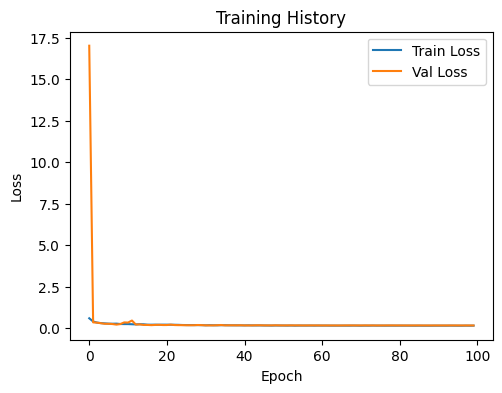

In [8]:
print("Training model...")
trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, num_epochs=100, learning_rate=1e-3
)

# Training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [9]:
def predict(model, device, image_tensor):
    """
    segmentation model -> binary mask
    """
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)  # (B, C, H, W)
        probs = torch.softmax(outputs, dim=1) 
        binary = probs[:, 1, :, :]  # foreground class
        binary = (binary > 0.5).cpu().float()
        return binary  # shape (B, H, W)

def count_and_draw(binary_mask, original_image, border_size=2, color=(0,255, 0)):
    """
    Đếm và vẽ các đối tượng từ ảnh binary (mask_resized) lên ảnh gốc.
    """
    # đếm trên binary
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_objects = len(contours)

    # Vẽ contours
    overlay = original_image.copy()
    cv2.drawContours(overlay, contours, -1, color, border_size)

    # Hiển thị kết quả bằng matplotlib
    plt.figure(figsize=(12, 5))

    # Hiển thị ảnh binary
    plt.subplot(1, 2, 1)
    plt.imshow(binary_mask, cmap='gray')
    plt.title('Binary Mask')
    plt.axis('off')

    # Hiển thị ảnh với contours
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f'Objects Detected: {num_objects}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return num_objects, contours


In [10]:
def preprocess_image(image):
    """
    Làm rõ biên và giảm nhiễu cho ảnh tế bào.
    """
    # Chuyển xám
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Làm mờ nhẹ để giảm nhiễu
    blur = cv2.GaussianBlur(gray, (3, 3), 0)

    # Tăng cường biên bằng CLAHE (adaptive histogram equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(blur)

    # Chuyển lại 3 kênh để phù hợp transform
    enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
    return enhanced_rgb


def pipline(model, device, image_path, border_size=2, color=(0, 0, 255)):
    """
    Load ảnh, tiền xử lý, dự đoán mask, resize, và count_and_draw.
    """
    # Load ảnh gốc
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    orig_h, orig_w = image.shape[:2]

    # Preprocess cho rõ biên tế bào
    image_rgb = preprocess_image(image)
    org_img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply transform
    transformed = test_transform(image=image_rgb)
    input_tensor = transformed["image"].unsqueeze(0)  # (1,3,256,256)

    # Predict binary mask
    pred_mask = predict(model, device, input_tensor)  # (1,H,W)
    binary_mask = pred_mask[0].numpy().astype(np.uint8)  # (H,W)

    # Resize mask về kích thước gốc ảnh
    mask_resized = cv2.resize(binary_mask, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)

    # count_and_draw
    num_objects, contours = count_and_draw(mask_resized, org_img_rgb, border_size=border_size, color=color)
    return num_objects

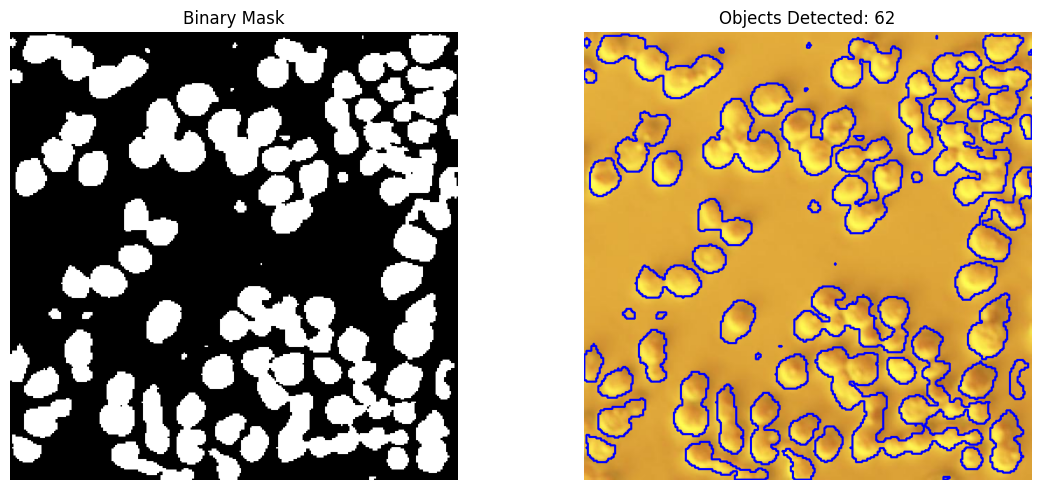

62

In [11]:
image_path = "/kaggle/input/cell-counting-roboflow-segmentation-masks/Cell_Counting_dataset_from_roboflow/test/images/Screenshot-2024-08-20-at-3-40-57-PM_png.rf.51490a3f822ef799797a83f5462ccc9a.jpg"
model = smp.Unet(
    encoder_name="resnet152",
    encoder_weights="imagenet",
    classes=2,
    activation=None,
)
model = nn.DataParallel(model)   
model.load_state_dict(torch.load("best_unet_model.pth", map_location=device))
model.to(device)
model.eval()

pipline(model,device,image_path)

# YOLOv8

In [12]:
# model = YOLO('yolov8n.pt')

# print("Bắt đầu huấn luyện...")
# results = model.train(
#     data='/kaggle/input/cell-counting-roboflow-segmentation-masks/Cell_Counting_dataset_from_roboflow/data.yaml',
#     epochs=100,
#     imgsz=640,
#     name='cell_detection_model'
# )
# print("Huấn luyện thành công!")

In [13]:
# model_path = '/kaggle/input/cell_counting/pytorch/default/1/best.pt'
# try:
#     model = YOLO(model_path)
# except Exception as e:
#     print(f"Lỗi khi tải mô hình tùy chỉnh: {e}")
#     exit()

# image_path = '/kaggle/input/cell-counting-roboflow-segmentation-masks/Cell_Counting_dataset_from_roboflow/test/images/Screenshot-2024-08-20-at-6-10-27-PM_png.rf.cf3e3aac50ec0abae4b45cb33971be50.jpg'
# try:
#     img = cv2.imread(image_path)
#     if img is None:
#         raise FileNotFoundError(f"Không thể đọc ảnh từ đường dẫn: {image_path}")
# except FileNotFoundError as e:
#     print(e)
#     exit()

# results = model(img, conf=0.5)

# cell_count = len(results[0])
# print(f"Phát hiện được tổng số: {cell_count} tế bào.")

# # --- 4. HIỂN THỊ KẾT QUẢ ---
# annotated_img = results[0].plot(labels=False, conf=False)

# # Hiển thị và lưu ảnh
# cv2_imshow(annotated_img)